<a href="https://colab.research.google.com/github/hayunjong83/computer_vision_implement_research/blob/master/PyTorch/Captum_Recipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Interpretability using Captum
원글 : [MODEL INTERPRETABILITY USING CAPTUM](https://pytorch.org/tutorials/recipes/recipes/Captum_Recipe.html)

PyTorch 공식페이지의 이번 예제는 Captum 패키지를 이용하여, 딥러닝 결과에 대한 해석을 제공한다. 

Captum은 GradCam이나 Integrated Gradients 같은 feature attribution algorithm을 통합된 방식으로 수행할 수 있게 돕는 오픈소스 패키지다.

## Captum

[Captum](https://captum.ai/)은 라틴어로 Comprehension을 뜻하며, 모델 해석(model interpretability)을 돕는 오픈소스 라이브러리다.

In [1]:
# installation
!pip install captum

     |████████████████████████████████| 1.4 MB 5.2 MB/s 


## Before you begin

Captum은 위에서처럼 pip 패키지로 설치할 수 있으며, conda 패키지로도 제공된다.

이번 예제는 Captum을 간단하게 설치한 뒤, torchvision로부터 간단한 image classification 모델을 선언한 뒤, Captum이 예측을 위해 활성화되는 부분을 어떻게 시각화하는 지를 보인다.

In [2]:
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

pretrained된 Resnet18 모델을 로드해서 학습 없이 예측만 수행한다.

In [3]:
model = torchvision.models.resnet18(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

예측을 수행할 이미지를 내려받는다.

In [4]:
response = requests.get("https://image.freepik.com/free-photo/two-beautiful-puppies-cat-dog_58409-6024.jpg")
img = Image.open(BytesIO(response.content))

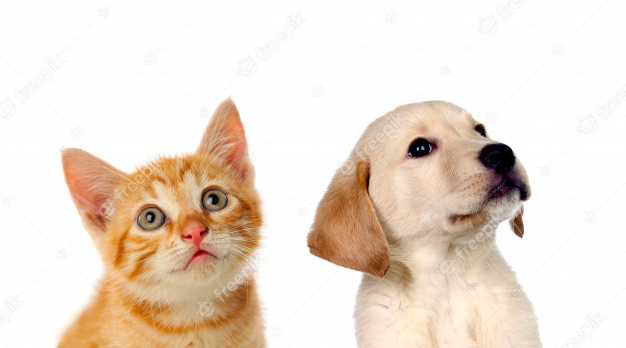

In [5]:
# 확인
display(img)

In [6]:
# 학습된 모델에 맞게 입력 이미지를 transform
center_crop = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
])

normalize = transforms.Compose([
            # converts the image to a tensor with values
            # between 0 and 1
            transforms.ToTensor(),
            # normalize to follow 0-centered imagenet pixel
            # rgb distribution
            transforms.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225]
            )
])
# transform 후에 모델 입력을 위해 배치차원을 포함시킨다.
input_img = normalize(center_crop(img)).unsqueeze(0)

## Computing Attribution

모델의 top-3 prediction은 입력 이미지에 속한 객체가 각각 ImageNet class index 208, 283에 해당된다고 예측한다. [imagenet1000_clsidx_to_labels.txt](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)를 참고하면, 208번 클래스는 래브라도 리트리버(Labrador retriever)이며, 283번 클래스는 페르시안 고양이(Persian cat)이다.

여기서는 [Occlusion](https://captum.ai/api/occlusion.html) 알고리즘을 사용하여 입력 이미지의 어떤 부분이 예측을 위해 활성화되는 지 알아본다.

아래에 사용된 parameter의 의미는 다음과 같다.



*   inputs : occlusion attribution이 계산될 입력 이미지
*   sliding_window_shapes : 알고리즘을 수행하는 patch(=hyperrectangle) 크기
*   strides : patch가 이동하는 간격
*   baselines : 찾으려는 feature가 occluded 되었을 때, 대체하려는 참조 값
*   target : 타겟 클래스의 인덱스



In [7]:
from captum.attr import Occlusion

occlusion = Occlusion(model)

# smaller = more fine-grained attribution but slower
strides = (3, 9, 9)
# choose size enough to change object apperance
sliding_window_shapes = (3, 45, 45)
# values to occlude the image with. 0 corresponds to gray
baselines = 0

In [8]:
# Labrador index in ImageNet
target = 208

attribution_dog = occlusion.attribute(input_img, 
                                      strides= strides,
                                      target= target,
                                      sliding_window_shapes= sliding_window_shapes,
                                      baselines=baselines)

# Persian cat index in ImageNet
target = 283

attribution_cat = occlusion.attribute(input_img,
                                      strides= strides,
                                      target= target,
                                      sliding_window_shapes= sliding_window_shapes,
                                      baselines= 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Occlusion 알고리즘 이외에도, Integrated Gradients, Deconvolution, GuidedBackprop, Guided GradCam, DeepLift, GradientShap 등의 방식을 사용해 볼 수 있다. 이런 알고리즘들은 모두 Attribution 의 서브 클래스로서, attribute() 메소드를 사용하면 결과를 반환하는 동일한 방식으로 동작한다.

## Visualizing the Results

원하는 시각화 방식을 지정한 후에, 파악한 attribution을 시각화하는 utility 함수를 Captum은 제공한다. 이 때 matplotlib의 figure로서 결과 이미지를 표현한다.

*    attr(numpy.array) : 시각화할 attribution에 해당하는 넘파이 배열. (H, W, C)
*    original_image(numpy.array) : 원본 이미지
*    method : 시각화 방법
*    sign : 시각화할 클래스 속성 결정

method로 지정할 수 있는 옵션은 다음과 같다.


1.   heat_map : 선택된 attribution에 대한 히트맵
2.   blended_heat_map : greyscale된 원본 이미지 위에 히트맵을 오버레이
3.   original_image : 원본 이미지
4.   masked_image : normalized 속성값으로 마스킹한 이미지
5.   alpha_scaling : normalized 속성값을 알파채널 투명도로 설정

sign으로 설정할 수 있는 옵션은 다음과 같다.

1.   positive : positive 클래스의 픽셀만 보인다.
2.   absolute_value : 속성의 절대값을 보인다.
3.   negative : negative 클래스의 픽셀만 보인다.
4.   all : positive, negative 클래스를 함께 보인다.

참고로, camp 옵션을 설정하지 않으면, positive sign은 초록색, negative sign은 빨간색, absolute value는 파란색으로 표현된다.






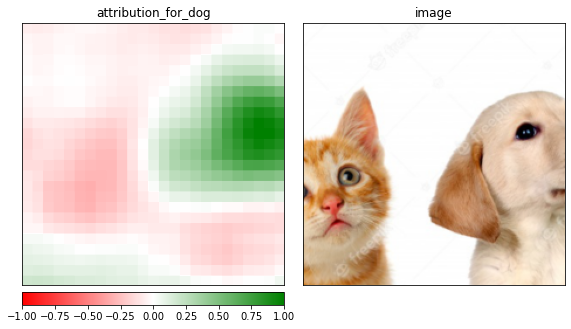

In [9]:
import numpy as np
from captum.attr import visualization as viz

# Convert the compute attribution tensor into an image-like numpy array
attribution_dog = np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"]

_ = viz.visualize_image_attr_multiple(attribution_dog, np.array(center_crop(img)),
                                     vis_types, vis_signs,
                                     ["attribution_for_dog", "image"],
                                     show_colorbar = True)

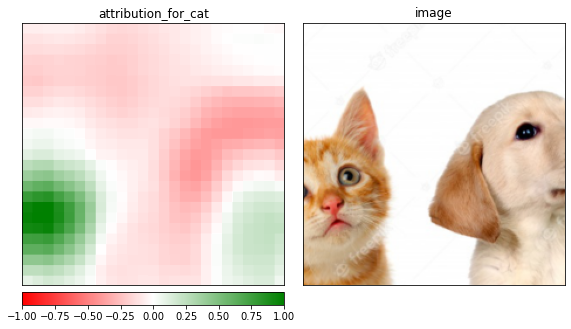

In [10]:
attribution_cat = np.transpose(attribution_cat.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution_cat, np.array(center_crop(img)),
                                      vis_types, vis_signs,
                                      ["attribution_for_cat", "image"],
                                      show_colorbar = True)